# Description
*author:* Vina My Pham<br>
*supervisor:* Robin van der Weide<br>
*project:* MSc internship project<br>
<br>
*date:* January 15 - July 26, 2024<br>
*host:* Kind group, Hubrecht Institute<br>
*university:* Bioinformatics, Wageningen University & Research<br>

---
Retrieve statistics on each plane of a label in a 3D matrix.

> Statistics include x- and y- range, area, perimeter. Circularity is calculated as $ 4π * area / (perimeter^2)$. Optional: report overlap with labels from another matrix.


---

**Input**<br>
- img matrix .tif `Z*X*Y`
- main labels .tif `Z * X * Y`

---
**Output**
- Label stats table with columns:
        0. label_id
        1. z_size
        2. median_x_size
        3. mad_x_size
        4. median_y_size
        5. mad_y_size
        6. median_area
        7. mad_area
        8. volume
        9. median_circularity
        10. mad_circularity

---
Additional code is provided to inspect the distribution of these statistics. This can be used to filter segmentations (e.g. those with unrealistic diameters).

## Notebook init

### import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)


Mounted at /content/gdrive


In [ ]:
from datetime import datetime
from IPython.display import display
import copy

import skimage.io
import numpy as np
import pandas as pd
import re
import cv2
import random
import tifffile

import skimage.measure

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### functions

#### main

In [ ]:
#functions
def get_label_stats(nuclear_labels_path, verbose=False):
    """
    Generate statistics for labeled regions in a 3D image volume.

    Args:
        nuclear_labels_path (numpy.ndarray): 3D array representing labeled
            regions. Z * X * Y
        verbose (bool): Whether to print progress verbose. Default: False

    Returns:
        pandas.DataFrame - DataFrame containing statistics for labeled regions.
            Columns:
                0. label_id (int): Unique identifier for each labeled region.
                1. iplane (int): Index of the image plane (slice) containing
                    the region.
                2. x0 (int): Minimum column index of the bounding box.
                3. x1 (int): Maximum column index of the bounding box.
                4. y0 (int): Minimum row index of the bounding box.
                5. y1 (int): Maximum row index of the bounding box.
                6. x_size (int): Range of columns covered by the region
                    (x1 - x0).
                7. y_size (int): Range of rows covered by the region
                    (y1 - y0).
                8. area (int): Area (number of pixels) of the region.
                9. perimeter (float): Perimeter (circumference) of the region.
                10. circularity (float): Measure of how closely the region
                    resembles a circle.
                    Calculated as 4 * pi * area / (perimeter^2).
    """

    #init
    iplanes = range(nuclear_labels_path.shape[0])
    label_stats_df = pd.DataFrame()

    for iplane in iplanes:
        #init
        iplane_matrix = nuclear_labels_path[iplane, :, :]
        iplane_label_ids = list(np.unique(iplane_matrix))
        if 0 in iplane_label_ids:
            iplane_label_ids.remove(0)

        if verbose: print(f"{datetime.now()}\t"+
                          f"{(iplane+1)/(iplanes[-1]+1)*100:.2f}%"+
                          f"\tProcessing iplane {iplane}" +
                          f"\t(n labels = {len(iplane_label_ids)}).")

        #basic stats
        iplane_regionprops = skimage.measure.regionprops_table(iplane_matrix,
                                               properties=('label', 'area',
                                                           'bbox', 'perimeter'))
        iplane_df = pd.DataFrame(iplane_regionprops)

        #rename columns
        iplane_df = iplane_df.rename(columns={'label': 'label_id',
                                               'bbox-1': 'x0',
                                               'bbox-0': 'y0',
                                               'bbox-3': 'x1',
                                               'bbox-2': 'y1'})

        #calculate x and y-ranges
        iplane_df['x_size'] = iplane_df['x1'] - iplane_df['x0']
        iplane_df['y_size'] = iplane_df['y1'] - iplane_df['y0']

        #calculate circularity
        iplane_df['circularity'] = 4 * np.pi * iplane_df['area'] / (iplane_df['perimeter'] ** 2)

        #add iplane column
        iplane_df['iplane'] = iplane

        #reorder columns, drop perimeter
        iplane_df = iplane_df[['label_id', 'iplane', 'x0', 'x1', 'y0', 'y1',
                               'x_size', 'y_size', 'area', 'circularity']]

        #add to the compiled df
        label_stats_df = pd.concat([label_stats_df, iplane_df], ignore_index=True)

    return label_stats_df

def include_overlap_in_df(df, reference_matrix, comparison_matrix):
    """
    Identify overlapping labels between two matrices and append the results as
    a new column to the DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame containing label statistics.
        reference_matrix (numpy.ndarray): Original matrix serving as the reference.
        comparison_matrix (numpy.ndarray): Matrix to compare against the reference.

    Returns:
        pandas.DataFrame: DataFrame with an additional column containing labels
                          from the comparison matrix within each region.
    """

    # init
    label_ids = df['label_id'].values
    iplanes = df['iplane'].values

    comparison_labels_in_regions = []

    for label_id, iplane in zip(label_ids, iplanes):
        # Get labels from the comparison matrix within the region
        labels_from_other_matrix_inside_region = get_comparison_ids_within_region(
                                                    reference_matrix[iplane],
                                                    label_id,
                                                    comparison_matrix[iplane])

        comparison_labels_in_regions.append(labels_from_other_matrix_inside_region)

    df['comparison_labels_in_region'] = comparison_labels_in_regions

    return df

#### helper

In [ ]:
def get_iplanes(mask_matrix, mask_id):
    """Get planes in which the mask id is present in a 3D matrix

    Args:
        mask_matrix (numpy.ndarray): 3D mask matrix
        mask_id (int): ID of the mask to search for

    Returns:
        list of ints - plane indices where the mask is present, sorted in
                       ascending order
    """
    planes = []
    for iplane in range(mask_matrix.shape[0]):
        if mask_id in mask_matrix[iplane,:,:]:
            planes.append(iplane)
    return sorted(planes)

#utils
def outlines_list(mask_matrix):
    """ get outlines of masks as a list to loop over for plotting

    Notes:
        outlines_list() cellpose v2.2.2
    """
    #print("DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from " +
    #      "cellpose.utils import")
    outline_px =[]

    mask_ids = list(np.unique(mask_matrix))
    if 0 in mask_ids:
        mask_ids.remove(0)

    for mask_id in mask_ids:
        mask_px = mask_matrix == mask_id
        contours = cv2.findContours(mask_px.astype(np.uint8),
                                    mode=cv2.RETR_EXTERNAL,
                                    method=cv2.CHAIN_APPROX_NONE)[-2]

        cmax = np.argmax([c.shape[0] for c in contours])
        pix = contours[cmax].astype(int).squeeze()
        if len(pix)>2:
            outline_px.append(pix)
        else:
            outline_px.append(np.zeros((0,2)))
    return outline_px

In [ ]:
def median_absolute_deviation(x):
    """Calculate the median absolute deviation (MAD) of an input array

    Args:
        x (array-like): array or DataFrame column to calculate MAD for

    Returns:
        flt - median absolute deviation of x
    """
    median = np.median(x)

    return np.median(np.abs(x - median))

In [ ]:
#helper
def get_comparison_ids_within_region(reference_matrix, reference_id, comparison_matrix, exclude_bg=False):
    """Return IDs from a matrix within a specific region in the reference matrix

    Args:
        matrices: 2d arrays of same size
        exclude_bg: remove 0 from the list

    Returns:
        list of ints - IDs from the comparison matrix
    """
    search_window = comparison_matrix[np.where(reference_matrix == reference_id)]
    comparison_ids = list(np.unique(search_window))
    comparison_id_counter = Counter(search_window)
    if 0 in comparison_id_counter: del comparison_id_counter[0]


    if exclude_bg:
        if 0 in comparison_ids:
            comparison_ids.remove(0)

    return comparison_ids, comparison_id_counter

#### reformatting

In [ ]:
#utils
def convert_labels_to_integers(label_matrix):
    """Convert label matrix to integers.

    Args:
        label_matrix (numpy.ndarray): Label matrix to be converted.

    Returns:
        numpy.ndarray: Converted label matrix with labels represented as integers.
    """
    converted = label_matrix.astype(int)

    # Check if the number of unique labels remains the same after conversion
    if len(np.unique(converted)) == len(np.unique(label_matrix)):
        print("Successfully converted labels into integers.")
        return converted
    else:
        raise ValueError("Change in the number of labels detected. Labels "+
                         "have not been converted into integers.")


#### report

In [ ]:
def print_aligned_data(data):
    """print data in aligned format

    Args:
        data (list of lists): data to be printed. Nested lists represents a
                              rows of data.

    Returns:
        N/A - function returns nothing.

    Example:
    >>> data = [["idx", "name", "img_path", "mask_path"],
                [0, "stack_01", "stack_01_img.tif", "stack_01_labels.tiff"],
                [1, "this_is_a_long_name", "short", "hello_world"]]
    >>> print_aligned_data(data)

        idx    name                   img_path            mask_path
        0      stack_01               stack_01_img.tif    stack_01_labels.tiff
        1      this_is_a_long_name    short               hello_world

    """
    #calculate custom column widths for input data
    column_widths = [max(len(str(item)) for item in column) for column in zip(*data)]

    for row in data:
        print("    ".join(f"{str(item):<{width}}" for item, width
                          in zip(row, column_widths)))

#### plot

In [ ]:
def plot(img_matrix, mask_matrix,
         iplanes, mask_id=False, channel=None,
         plot_type='outlines', figsize=(10,10), save=False):
    """
    mask_id (False, or int): if False or 0, all masks will be plotted. Else a specific mask under that id will be plotted.
    """
    nplots = len(iplanes)
    fig = plt.figure(figsize=figsize)

    for idx, iplane in enumerate(iplanes, 1):
        plt.subplot(1, nplots, idx)

        if channel == None: #stack all channels
            plotted_img_matrix = np.dstack((img_matrix[iplane, :,:,2],img_matrix[iplane, :,:,1],img_matrix[iplane, :,:,0])) #DAPI: blue, LaminB1: green, H3K4me3: red
            #np.dstack(tuple(img_matrix[iplane,:,:,channel] for channel in range(img_matrix.shape[-1])))
        else: #select only one channel to show
            plotted_img_matrix = img_matrix[iplane,:,:,channel]

        plt.imshow(plotted_img_matrix, cmap=plt.cm.gray)
        plt.title(f"plane {iplane}")
        plt.axis("off")

        if plot_type == 'outlines':

            #plot all outlines
            mask = copy.deepcopy(mask_matrix[iplane, :, :])
            for o in outlines_list(mask):
                plt.plot(o[:,0], o[:,1], color='orange')

            #highlight the selected mask
            if mask_id:
                #if mask_id not in mask:
                #    raise ValueError(f"No mask with mask_id={mask_id} present")

                mask[~np.isin(mask,[mask_id])] = 0

                #COLOUR IN MASK
                #mask = np.ma.masked_where(mask == 0, mask)
                #plt.imshow(mask)

                #OUTLINE THE MASK
                for o in outlines_list(mask):
                    plt.plot(o[:,0], o[:,1], color='w')

        elif plot_type == 'fill':
            #all masks present in the window
            if mask_id:

                mask = copy.deepcopy(mask_matrix[iplane, :, :])
                mask[~np.isin(mask,[mask_id])] = 0
                mask = np.ma.masked_where(mask == 0, mask)
                plt.imshow(mask, cmap='prism', alpha=0.5)

            else:

                mask = copy.deepcopy(mask_matrix[iplane, :, :])
                mask = np.ma.masked_where(mask == 0, mask)
                plt.imshow(mask, cmap='prism', alpha=0.5)


    #plt.suptitle(f"mask {mask_id}" if mask_id else "", y=0.7)
    plt.tight_layout()

    if save: plt.savefig(save)
    #plt.show();

    return fig

# File loading
- img_matrix_path: path to .TIF of the confocal stack
- labels_path: path to .TIF of 3D labels. Can be nuclei or spots.
- name: arbitrary identifier for the stack
- mode: the type of labels. used in the titles of plots (e.g. "nuclei" or "spots")

In [ ]:
img_matrix_path = "/content/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D40.tif" #@param {type:"string"}
labels_path = "/content/D40_nuclei_all_encapsulated_spots.tif" #@param {type:"string"}
name="D40" #@param {type:"string"}
mode = 'nuclei' #@param {type:"string"}

#@markdown <br> **scaling factors**
scale=True #@param {type:"boolean"}
xscale=0.11 #@param
yscale=0.11 #@param
zscale=0.05 #@param
scaling_list = [zscale,xscale,yscale]

#data loading
img_matrix = skimage.io.imread(img_matrix_path)
label_matrix = skimage.io.imread(labels_path)

#stats
iplanes = range(label_matrix.shape[0])
label_ids = list(np.unique(label_matrix))

#report
print("img_matrix shape (Z * X * Y * channels): ", img_matrix.shape)
print("label_matrix shape (Z * X * Y): ", label_matrix.shape)
print("iplanes: ", len(iplanes))
print(f"\nscaled Z*X*Y: ({[scaling_list[i]*shape[i] for i in range(len(scaling_list))]})" )
print("\nlen label_ids: ", len(label_ids))

# Pre-process

- Turn labels from floats into integers<br>
> Make sure that that it does not change the information (e.g. .csv has floats due to accidental Pandas conversion)

Dev note:
- Change export functions in previous notebooks to retain integers.

In [ ]:
label_matrix = convert_labels_to_integers(label_matrix)

Successfully converted labels into integers.


# Get stats and scale

**Description:**

---

**Input:**
- `img_matrix` (see section #Input files)
- `nuclear_labels_path` (see section #Input files)

**Returns:**
- `label_stats_df`: pd.DF with columns:
        0. label_id: Unique identifier for each labeled region.
        1. iplane: Index of the image plane (slice) containing the region.
        2. x0: Minimum column index of the bounding box.
        3. x1: Maximum column index of the bounding box.
        4. y0: Minimum row index of the bounding box.
        5. y1: Maximum row index of the bounding box.
        6. area: Area (number of pixels) of the region.
        7. perimeter: Perimeter (circumference) of the region.
        8. circularity: Measure of how closely the region resembles a circle. Calculated as 4 * π * area / (perimeter^2).


In [ ]:
label_stats_df = get_label_stats(label_matrix, verbose=False)

print('label_stats_df preview:')
display(label_stats_df.head())

print(f"scale = {scale}")
if scale:
    print("AFTER SCALING x_size, y_size, area")
    label_stats_df['x_size'] = label_stats_df['x_size'] * xscale
    label_stats_df['y_size'] = label_stats_df['y_size'] * yscale
    label_stats_df['area'] = label_stats_df['area'] * xscale * yscale

    display(label_stats_df.head())

label_stats_df preview:


,label_id,iplane,x0,x1,y0,y1,x_size,y_size,area,circularity
0,3,0,69,99,234,255,30,21,493,0.886472
1,5,0,317,341,244,269,24,25,444,0.886014
2,6,0,290,319,245,266,29,21,454,0.827908
3,7,0,239,268,259,285,29,26,569,0.951906
4,9,0,354,371,275,292,17,17,219,0.963083


scale = True
AFTER SCALING x_size, y_size, area


,label_id,iplane,x0,x1,y0,y1,x_size,y_size,area,circularity
0,3,0,69,99,234,255,5.10,3.57,14.2477,0.886472
1,5,0,317,341,244,269,4.08,4.25,12.8316,0.886014
2,6,0,290,319,245,266,4.93,3.57,13.1206,0.827908
3,7,0,239,268,259,285,4.93,4.42,16.4441,0.951906
4,9,0,354,371,275,292,2.89,2.89,6.3291,0.963083


# 3D segmentation summary stats

## scale Z if scale=True

In [ ]:
stack_label_stats_df = label_stats_df.groupby('label_id').agg(
    z_size=('iplane', 'nunique'),
    median_x_size=('x_size', 'median'),
    mad_x_size=('x_size', median_absolute_deviation),
    median_y_size=('y_size', 'median'),
    mad_y_size=('y_size', median_absolute_deviation),
    median_area=('area', 'median'),
    mad_area=('area', median_absolute_deviation),
    volume=('area', 'sum'),
    median_circularity=('circularity', 'median'),
    mad_circularity=('circularity', median_absolute_deviation)
).reset_index()


if scale:
    stack_label_stats_df['z_size'] = stack_label_stats_df[['z_size']].multiply(zscale)

display(stack_label_stats_df)

,label_id,z_size,median_x_size,mad_x_size,median_y_size,mad_y_size,median_area,mad_area,volume,median_circularity,mad_circularity
0,3,4.55,5.440,0.170,5.100,0.170,19.91210,1.06930,1757.0333,0.879152,0.015748
1,5,2.75,4.420,0.000,4.930,0.170,16.27070,0.75140,877.3462,0.887946,0.015495
2,6,2.70,4.760,0.170,3.570,0.340,13.23620,0.92480,670.3644,0.863481,0.013435
3,7,1.65,4.930,0.000,4.590,0.000,16.76200,0.37570,518.2926,0.931166,0.015044
4,9,4.10,4.760,0.680,4.165,0.765,14.43555,4.49395,1168.3692,0.899092,0.019811
...,...,...,...,...,...,...,...,...,...,...,...
184,522,2.25,6.120,0.170,3.570,0.000,15.80830,0.40460,692.1550,0.788007,0.016826
185,538,1.10,4.505,0.255,4.250,0.170,13.30845,1.63285,295.4736,0.823110,0.046263
186,541,1.25,4.420,0.340,3.570,0.170,11.15540,1.01150,276.7175,0.865483,0.023786
187,631,1.45,4.590,0.170,3.910,0.170,13.09170,1.21380,354.8631,0.836456,0.035132


In [ ]:
#@markdown [pair plot]
plot_pairplot=False

if plot_pairplot:
    plot = sns.pairplot(stack_label_stats_df[['z_size', 'median_x_size', 'median_y_size', 'median_area', 'volume']],
                        diag_kind="kde")

    #adding x=y line
    for ax in plot.axes.flatten():
        #plotting x=y line through the plots
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color='red')

        #resetting x and y axis to the orignal range
        #ax.set_xlim(xlim)
        #ax.set_ylim(ylim)

    plt.show()

#[optional] Export the statistic matrix


In [ ]:
stack_label_stats_df.to_csv(f"./{name}_{mode}_statistics.csv")

# Outlier detection using MAD-from-median approach


In [ ]:
#user settings
selected_column = 'volume' #@param ['z_size', 'median_x_size', 'median_y_size', 'median_area', 'volume']
#, 'median_circularity']
unit = {'z_size':'μm',
        'median_x_size':'μm',
        'median_y_size':'μm',
        'median_area':'μm²',
        'volume':'μm³'} #,
        #'median_circularity':''}.get(selected_column)
n_mad = 0 #@param
display_df = False

columns_sets_to_plot = [['z_size', 'median_x_size', 'median_y_size'],
                        ['median_area'],
                        ['volume']] #,
                        #['median_circularity']]

y_label_dict= {0 : 'μm',
               1 : 'μm²',
               2 : 'μm³'}


In [ ]:
#@markdown [code: filtering `stack_label_stats_df`]<br>
#@markdown [returns: `filtered_using_mad_df`, `mad_outlier_df`]
## FILTERING
filter = "custom" #@param ["two_sided", "lower_limit", "upper_limit", "custom"]
#@markdown custom limit (lower and upper limit)
custom = [16, np.inf] #@param

# calculate median
median_value = stack_label_stats_df[selected_column].median()

# calculate MAD
mad_value = median_absolute_deviation(stack_label_stats_df[selected_column])

if filter=='two_sided':
    filtered_using_mad_df = stack_label_stats_df[(stack_label_stats_df[selected_column]<=(median_value+(mad_value*n_mad))) &
                                        (stack_label_stats_df[selected_column]>=(median_value-(mad_value*n_mad)))]

    mad_outlier_df = stack_label_stats_df[(stack_label_stats_df[selected_column]>(median_value+(mad_value*n_mad))) |
                                        (stack_label_stats_df[selected_column]<(median_value-(mad_value*n_mad)))]

if filter=='lower_limit':
    filtered_using_mad_df = stack_label_stats_df[(stack_label_stats_df[selected_column]>=(median_value-(mad_value*n_mad)))]
    mad_outlier_df = stack_label_stats_df[(stack_label_stats_df[selected_column]<(median_value-(mad_value*n_mad)))]

if filter=='upper_limit':
    filtered_using_mad_df = stack_label_stats_df[(stack_label_stats_df[selected_column]<=(median_value+(mad_value*n_mad)))]
    mad_outlier_df = stack_label_stats_df[(stack_label_stats_df[selected_column]>(median_value+(mad_value*n_mad)))]

if filter=='custom':
    filtered_using_mad_df = stack_label_stats_df[(stack_label_stats_df[selected_column]<=custom[1]) &
                                        (stack_label_stats_df[selected_column]>=custom[0])]

    mad_outlier_df = stack_label_stats_df[(stack_label_stats_df[selected_column]>custom[1]) |
                                          (stack_label_stats_df[selected_column]<custom[0])]

#report
print(f"selected column = {selected_column}")
if filter != 'custom': print(f"n mad = {n_mad}\n")
print("--STATS--")

if filter != 'custom': print(f"median = {median_value:.2f} (MAD = {mad_value:.2f})")
if filter=='two_sided': print(f"median -+ {n_mad} MAD: [{median_value-n_mad*mad_value:.2f}{unit}, {median_value+n_mad*mad_value:.2f}{unit}]")
if filter=='lower_limit': print(f"median - {n_mad} MAD: [{median_value-n_mad*mad_value:.2f}{unit}, ...]")
if filter=='upper_limit': print(f"median + {n_mad} MAD: [..., {median_value+(mad_value*n_mad):.2f}{unit}]")
if filter=='custom': print(f"custom range [{custom[0]}, {custom[1]}]")
print("n inliers: ", filtered_using_mad_df.shape[0])
print("n outliers: ", mad_outlier_df.shape[0], end='')
print(f" ({(mad_outlier_df.shape[0]) / (filtered_using_mad_df.shape[0]+mad_outlier_df.shape[0]) * 100:.2f}%)")

if display_df:
    display(filtered_using_mad_df)
    display(mad_outlier_df)


selected column = volume
--STATS--
custom range [16, inf]
n inliers:  189
n outliers:  0 (0.00%)


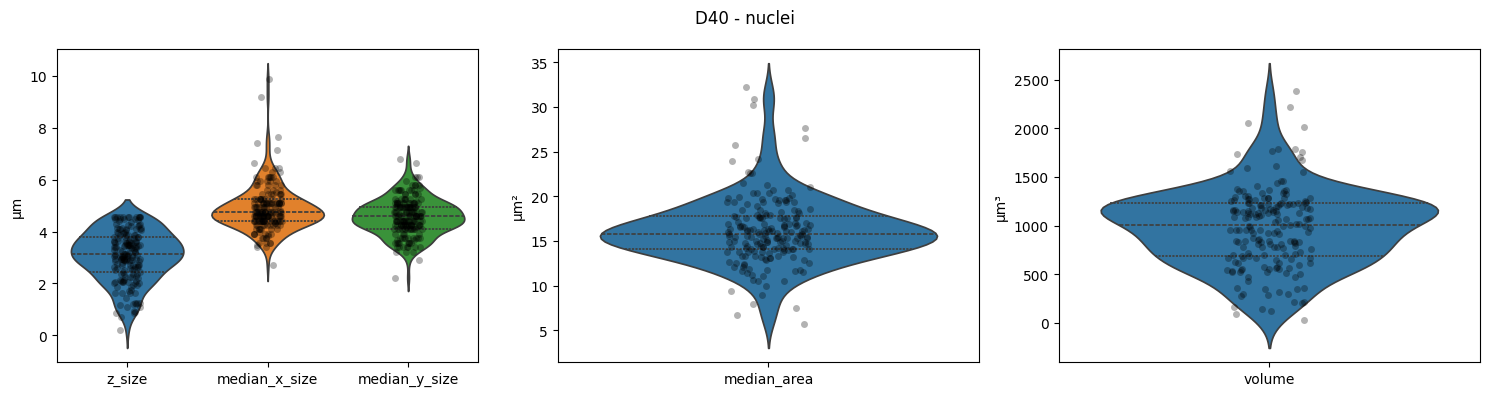

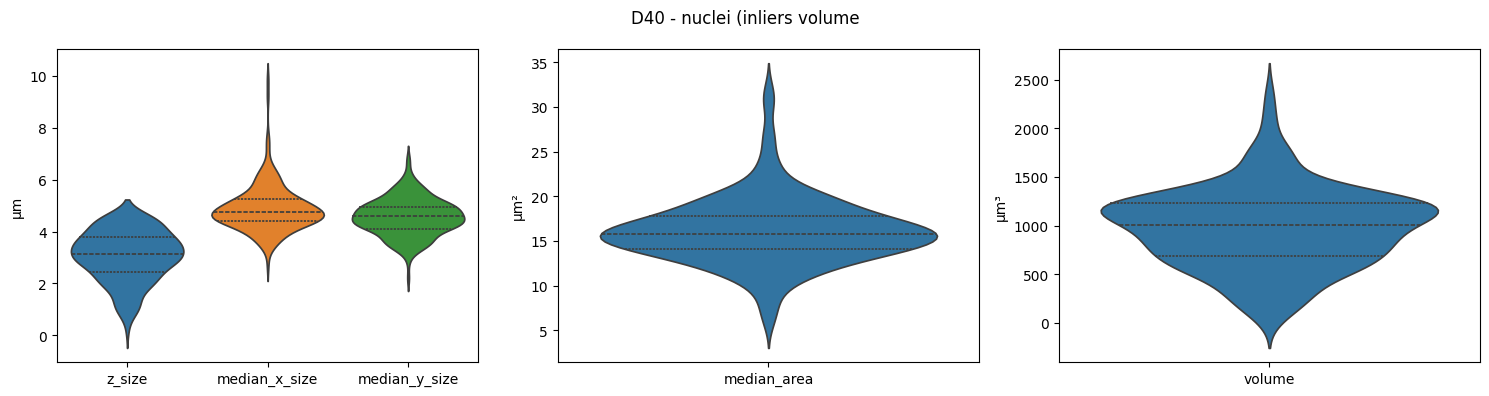

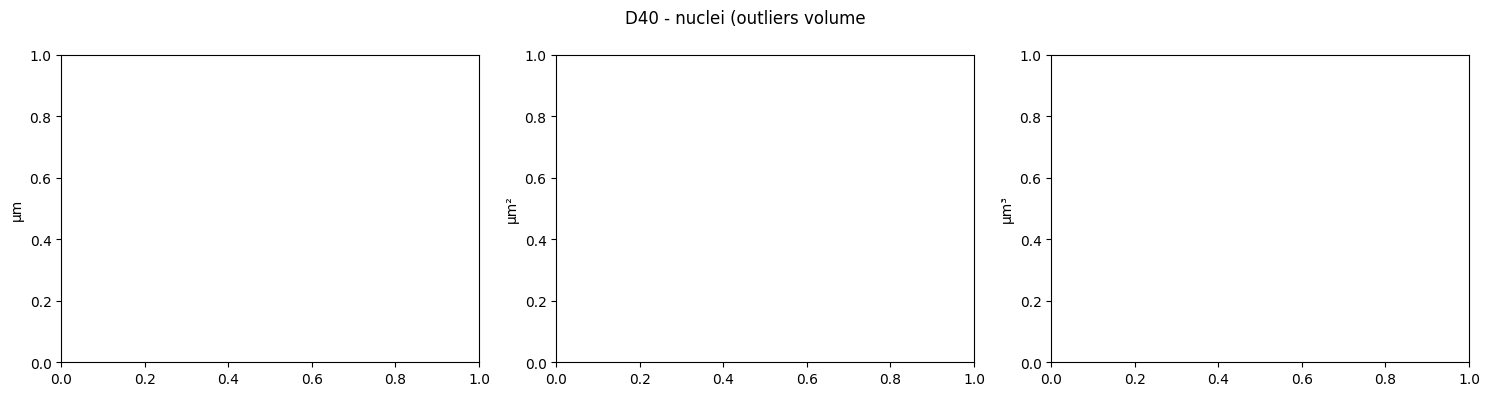

In [ ]:
#@markdown [code: show distribution, unfiltered, inliers and outliers]

# plot distribution - unfiltered
plt.figure(figsize=(len(columns_sets_to_plot)*5, 4))

for i, columns_to_plot in enumerate(columns_sets_to_plot, 1):
    plt.subplot(1, len(columns_sets_to_plot), i)
    sns.violinplot(data=stack_label_stats_df[columns_to_plot],
                   inner='quart',
                   density_norm='width')
    sns.stripplot(data=stack_label_stats_df[columns_to_plot], color='black', alpha=0.3)
    plt.ylabel(y_label_dict.get(i-1, ''))

plt.suptitle(f"{name} - {mode}")# (unfiltered)")
plt.tight_layout()
plt.show()

# plot distribution - inliers
plt.figure(figsize=(len(columns_sets_to_plot)*5, 4))

for i, columns_to_plot in enumerate(columns_sets_to_plot, 1):
    plt.subplot(1, len(columns_sets_to_plot), i)
    sns.violinplot(data=filtered_using_mad_df[columns_to_plot],
                   inner='quart',
                   density_norm='width')
    plt.ylabel(y_label_dict.get(i-1, ''))

plt.suptitle(f"{name} - {mode} (inliers {selected_column}")# (>= MEDIAN - {n_mad} MAD))")
plt.tight_layout()
plt.show()

# plot distribution - outliers
plt.figure(figsize=(len(columns_sets_to_plot)*5, 4))

for i, columns_to_plot in enumerate(columns_sets_to_plot, 1):
    plt.subplot(1, len(columns_sets_to_plot), i)
    sns.violinplot(data=mad_outlier_df[columns_to_plot],
                   inner='quart',
                   density_norm='width')
    plt.ylabel(y_label_dict.get(i-1, ''))

plt.suptitle(f"{name} - {mode} (outliers {selected_column}")# (< MEDIAN - {n_mad} MAD))")
plt.tight_layout()
plt.show()

In [ ]:
display(mad_outlier_df.sort_values(by=selected_column, ascending=True))
print(f"selected column: {selected_column}")
if filter=='two_sided': print(f"median -+ {n_mad} MAD: [{median_value-n_mad*mad_value:.2f}{unit}, {median_value+n_mad*mad_value:.2f}{unit}]")
if filter=='lower_limit': print(f"median -+ {n_mad} MAD: [{median_value-n_mad*mad_value:.2f}{unit}, ...]")
if filter=='upper_limit': print(f"median + {n_mad} MAD: [..., {median_value+(mad_value*n_mad):.2f}{unit}]")

,label_id,z_size,median_x_size,mad_x_size,median_y_size,mad_y_size,median_area,mad_area,volume,median_circularity,mad_circularity


selected column: volume


In [ ]:
try:
    stack_label_stats_df['timepoint'] = name
    compiled_df = pd.concat([compiled_df, stack_label_stats_df], ignore_index=True)
except NameError:
    compiled_df = copy.deepcopy(stack_label_stats_df)
    compiled_df['timepoint'] = name

display(compiled_df)

,label_id,z_size,median_x_size,mad_x_size,median_y_size,mad_y_size,median_area,mad_area,volume,median_circularity,mad_circularity,timepoint
0,3,1.55,5.060,0.110,5.06,0.22,17.42400,0.24200,540.7611,0.768144,0.043835,D25
1,4,1.85,3.850,0.110,6.60,0.33,19.16640,0.62920,687.0985,0.719795,0.015178,D25
2,5,3.10,4.730,0.110,4.73,0.22,13.37050,0.67155,804.9283,0.700032,0.016447,D25
3,6,1.95,8.470,0.330,4.73,0.33,18.22260,0.56870,684.2671,0.507373,0.019778,D25
4,7,3.90,6.325,0.825,4.18,0.11,18.36780,1.84525,1494.3016,0.754897,0.053002,D25
...,...,...,...,...,...,...,...,...,...,...,...,...
1017,522,2.25,6.120,0.170,3.57,0.00,15.80830,0.40460,692.1550,0.788007,0.016826,D40
1018,538,1.10,4.505,0.255,4.25,0.17,13.30845,1.63285,295.4736,0.823110,0.046263,D40
1019,541,1.25,4.420,0.340,3.57,0.17,11.15540,1.01150,276.7175,0.865483,0.023786,D40
1020,631,1.45,4.590,0.170,3.91,0.17,13.09170,1.21380,354.8631,0.836456,0.035132,D40


In [ ]:
compiled_df.to_csv('statistics_nuclei_fully_encapsulated_spots.csv')

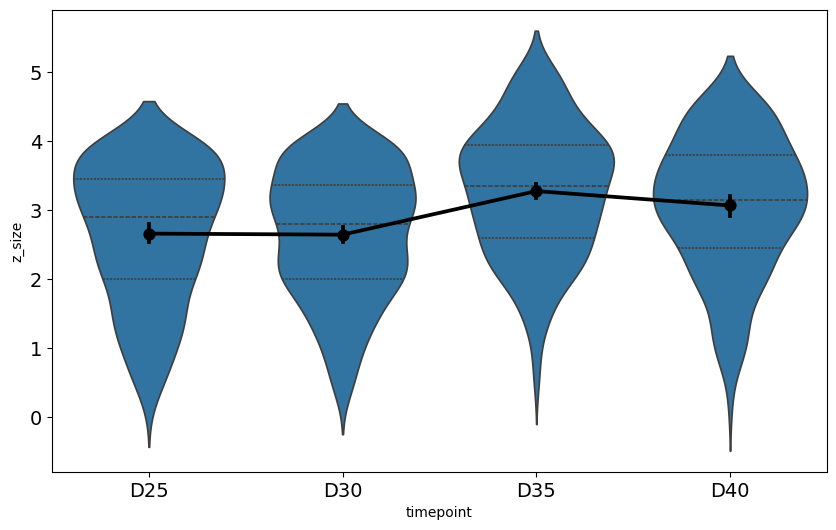

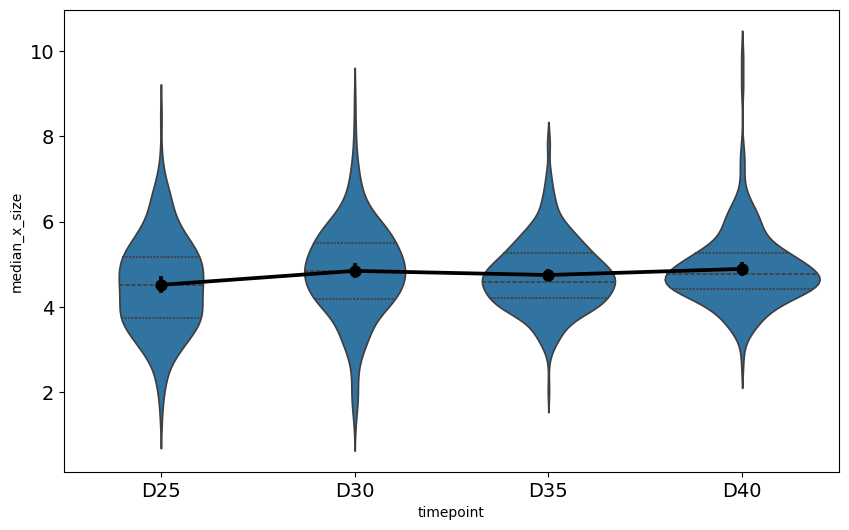

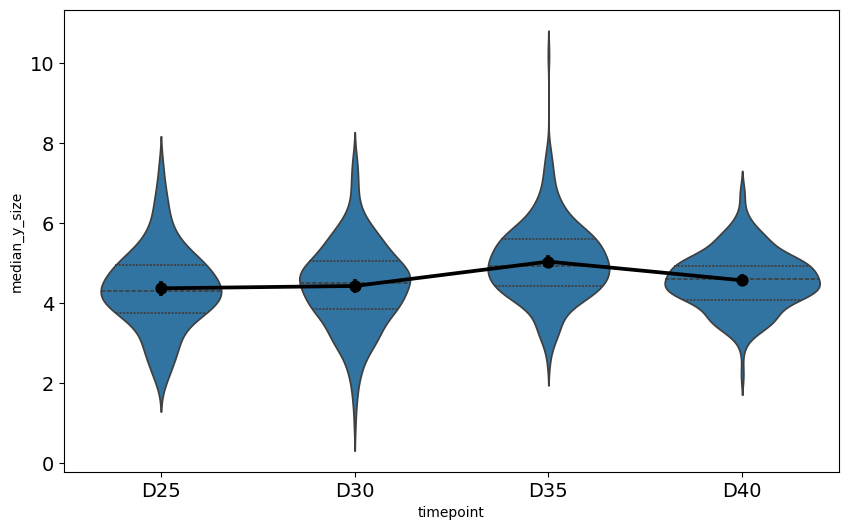

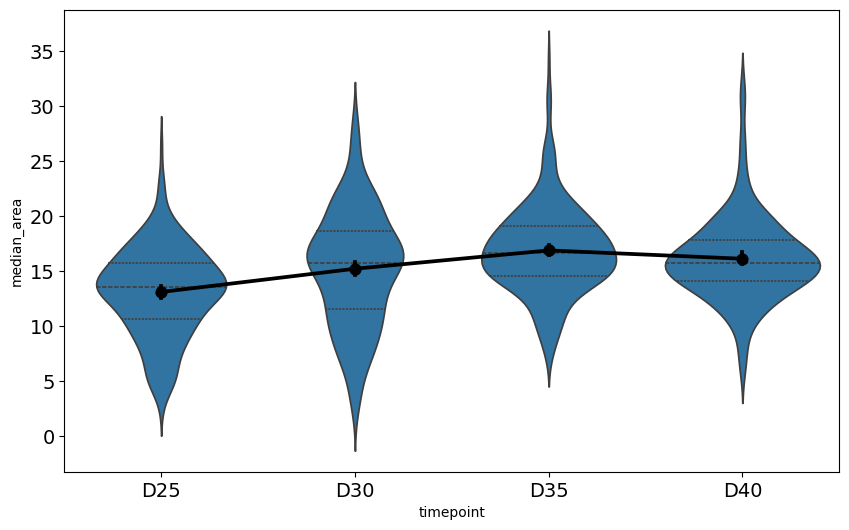

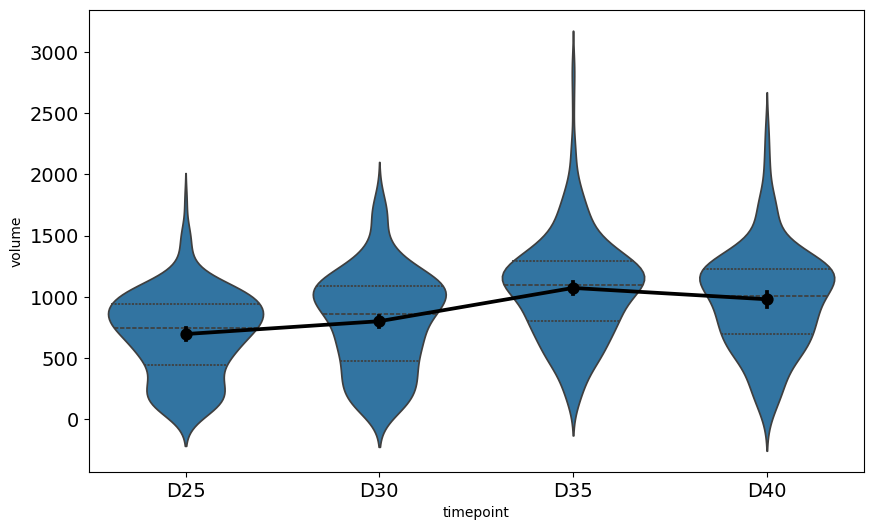

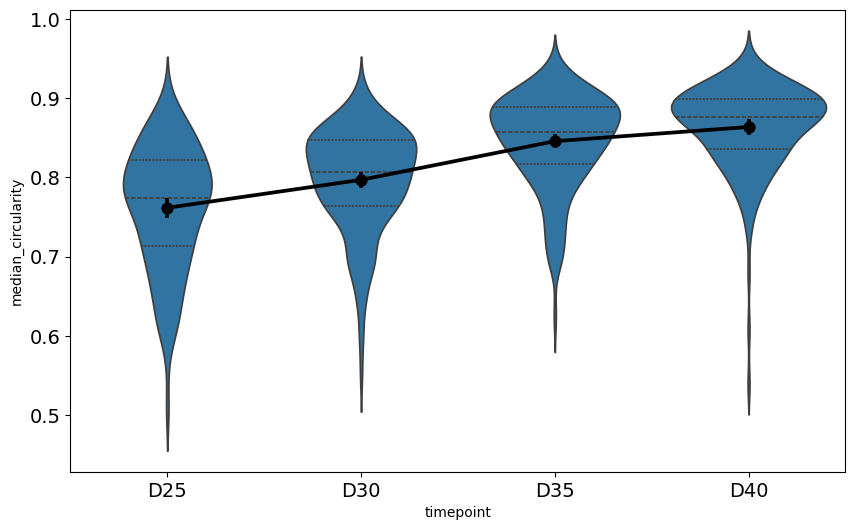

In [ ]:
plot_cols = ["z_size", "median_x_size", "median_y_size", "median_area", "volume", "median_circularity"]

for plot_col in plot_cols:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='timepoint', y=plot_col, data=compiled_df, inner='quart')
    sns.pointplot(x='timepoint', y=plot_col, data=compiled_df,
                  color='black', markers='o')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel('timepoint')
    plt.ylabel(plot_col)

    plt.show();

# Filter with all filters

In [ ]:
#init
final_filtered_df = copy.deepcopy(stack_label_stats_df)
filters = [["name", "column", "min_val", "max_val", "filter_type"]]

x=3

column = 'z_size'
filter_type = f"z_size >={x} planes ({x}*zscale)" #description of motivation
min_val = x*zscale
max_val = np.inf

# get data
final_filtered_df = final_filtered_df[(final_filtered_df[column] >= min_val) &
                                      (final_filtered_df[column] <= max_val)] #continue with filtered df

final_outliers_df = stack_label_stats_df[(stack_label_stats_df[column] < min_val) |
                                      (stack_label_stats_df[column] > max_val)]

# report
filters.append([name, column, min_val, max_val, filter_type])
print_aligned_data(filters)

#report
print("\n--STATS--")

print("n inliers: ", final_filtered_df.shape[0])
print("n outliers: ", final_outliers_df.shape[0], end='')
print(f" ({(final_outliers_df.shape[0]) / (final_filtered_df.shape[0]+final_outliers_df.shape[0]) * 100:.2f}%)")


name    column    min_val                max_val    filter_type                 
D25     z_size    0.15000000000000002    inf        z_size >=3 planes (3*zscale)

--STATS--
n inliers:  1959
n outliers:  0 (0.00%)


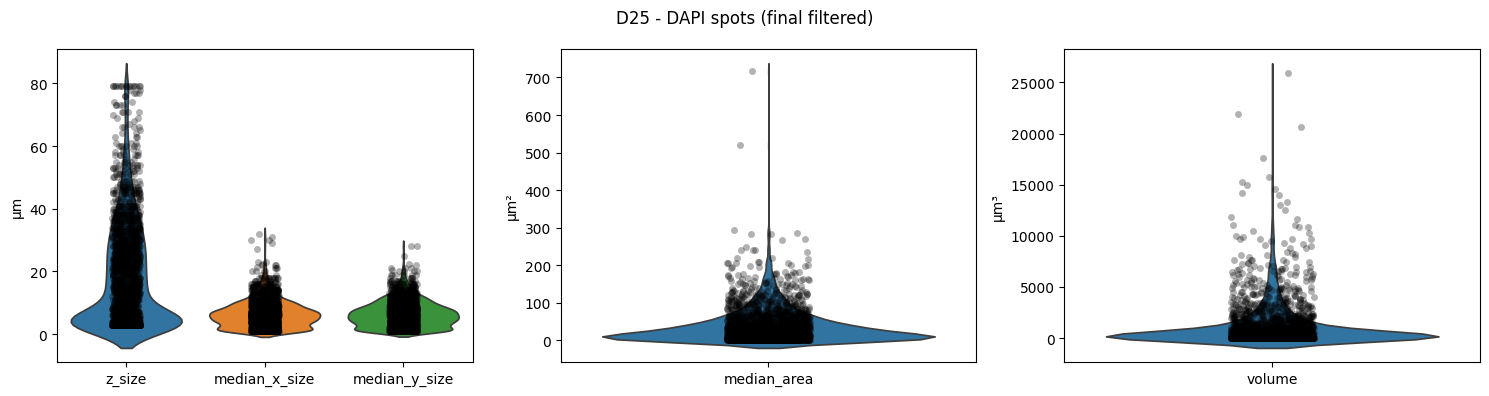

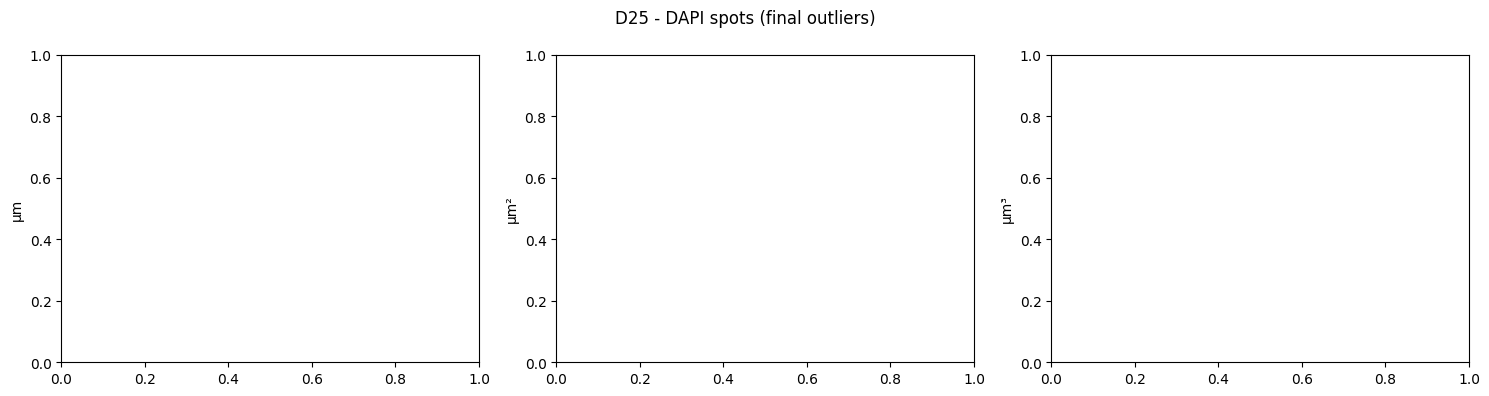

In [ ]:
# plot distribution - filtered
plt.figure(figsize=(len(columns_sets_to_plot)*5, 4))

for i, columns_to_plot in enumerate(columns_sets_to_plot, 1):
    plt.subplot(1, len(columns_sets_to_plot), i)
    sns.violinplot(data=final_filtered_df[columns_to_plot],
                   inner=None,
                   density_norm='width')
    sns.stripplot(data=final_filtered_df[columns_to_plot],
                  color='black',
                  alpha=0.3,
                  jitter=True)
    plt.ylabel(y_label_dict.get(i-1, ''))

plt.suptitle(f"{name} - {mode} (final filtered)")
plt.tight_layout()
plt.show()

# plot distribution - outliers
plt.figure(figsize=(len(columns_sets_to_plot)*5, 4))

for i, columns_to_plot in enumerate(columns_sets_to_plot, 1):
    plt.subplot(1, len(columns_sets_to_plot), i)
    sns.violinplot(data=final_outliers_df[columns_to_plot],
                   inner=None,
                   density_norm='width')
    sns.stripplot(data=final_outliers_df[columns_to_plot],
                  color='black',
                  alpha=0.3,
                  jitter=True)
    plt.ylabel(y_label_dict.get(i-1, ''))

plt.suptitle(f"{name} - {mode} (final outliers)")
plt.tight_layout()
plt.show()

In [ ]:
#report

#pre-filtering
print('---PRE-FILTER---')
for idx, column in enumerate(['z_size', 'median_x_size', 'median_y_size', 'median_area']):
    median_value = stack_label_stats_df[column].median()
    mad_value = median_absolute_deviation(stack_label_stats_df[column])

    print(f"\n{column}")
    print(f"median = {median_value:.2f}{y_label_dict.get(idx)} (MAD = {mad_value:.2f}{y_label_dict.get(idx)})")
    print(f"range: [{stack_label_stats_df[column].min():.2f}{y_label_dict.get(idx)}, {stack_label_stats_df[column].max():.2f}{y_label_dict.get(idx)}]")

#post-filtering
print('\n---POST-FILTER---')
for idx, column in enumerate(['z_size', 'median_x_size', 'median_y_size', 'median_area']):
    median_value = final_filtered_df[column].median()
    mad_value = median_absolute_deviation(final_filtered_df[column])

    print(f"\n{column}")
    print(f"median = {median_value:.2f}{y_label_dict.get(idx)} (MAD = {mad_value:.2f}{y_label_dict.get(idx)})")
    print(f"range: [{final_filtered_df[column].min():.2f}{y_label_dict.get(idx)}, {final_filtered_df[column].max():.2f}{y_label_dict.get(idx)}]")



---PRE-FILTER---

z_size
median = 13.00μm (MAD = 10.00μm)
range: [3.00μm, 79.00μm]

median_x_size
median = 6.00μm² (MAD = 3.00μm²)
range: [1.00μm², 32.00μm²]

median_y_size
median = 6.00μm³ (MAD = 3.00μm³)
range: [1.00μm³, 28.00μm³]

median_area
median = 24.00None (MAD = 20.00None)
range: [1.00None, 717.00None]

---POST-FILTER---

z_size
median = 13.00μm (MAD = 10.00μm)
range: [3.00μm, 79.00μm]

median_x_size
median = 6.00μm² (MAD = 3.00μm²)
range: [1.00μm², 32.00μm²]

median_y_size
median = 6.00μm³ (MAD = 3.00μm³)
range: [1.00μm³, 28.00μm³]

median_area
median = 24.00None (MAD = 20.00None)
range: [1.00None, 717.00None]


In [ ]:
ids_to_remove =list(final_outliers_df['label_id'])

print("\nname")
print(name)

print("\nlabel_path")
print(nuclear_labels_path)

print("\nids_to_remove")
print(ids_to_remove)
print()

In [ ]:
!rm *.*

# Remove outliers from the matrix

In [ ]:
name, img_matrix_path, nuclear_labels_path, chromocentre_labels_path = paths[4]

print(f"name: {name}")
print(f"img_matrix_path: {img_matrix_path}")
print(f"nuclear_labels_path: {nuclear_labels_path}")
print(f"chromocentre_labels_path: {chromocentre_labels_path}")




name: SPE20230317_D40
img_matrix_path: /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D40.tif
nuclear_labels_path: /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x_merge_fragmented_cellpose3D/SPE_20230327_D40_stitched.tiff
chromocentre_labels_path: /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/merge0/merge0SPE_20230327_D40_foci_stitched.tiff


In [ ]:
refined_label_matrix = skimage.io.imread(chromocentre_labels_path)
refined_label_matrix[np.isin(refined_label_matrix, ids_to_remove)] = 0



In [ ]:
outfile_name = f"{name}_cc_minz{x}.tif"
tifffile.imwrite(outfile_name, refined_label_matrix, bigtiff=True)

In [ ]:
!zip SPE20230327_cc_minz3.zip *minz3.tif

  adding: SPE20230317_D25_cc_minz3.tif (deflated 100%)
  adding: SPE20230317_D30_cc_minz3.tif (deflated 100%)
  adding: SPE20230317_D35_cc_minz3.tif (deflated 100%)
  adding: SPE20230317_D40_cc_minz3.tif (deflated 100%)


In [ ]:
!mv /content/SPE20230327_minz6.zip /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/06_QC_matrices/1.nuclear_segmentations

In [ ]:
!unzip /content/SPE_20230327_D25_stitched.zip

Archive:  /content/SPE_20230327_D25_stitched.zip
  inflating: SPE_20230327_D25_stitched.tiff  


# Filtering based on CC spillage

# Determine fullness

In [ ]:
#@markdown [def calculate_avg_radius_in_biggest_area]
from scipy.spatial import distance
def calculate_avg_radius_in_biggest_area(matrix, mask_id, label_stats_df, scale=False, verbose=False):
    #get plane with largest area in the nucleus
    mask_largest_area = label_stats_df[
                            label_stats_df['label_id']==mask_id].sort_values(
                                by=['area'], ascending=False).head(1)
    if verbose: print(mask_largest_area)
    iplane = mask_largest_area['iplane'].iloc[0]
    if verbose: print(iplane)

    iplane_matrix = matrix[iplane, :, :]

    #isolate mask
    mask = iplane_matrix == mask_id

    #show the mask, isolated
    if verbose:
        plt.imshow(mask)
        plt.title(f'mask {mask_id} in iplane {iplane}')
        plt.show();

    #get centrepoint of mask
    x0 = mask_largest_area['x0'].iloc[0]
    x1 = mask_largest_area['x1'].iloc[0]
    y0 = mask_largest_area['y0'].iloc[0]
    y1 = mask_largest_area['y1'].iloc[0]

    centre = [x0+((x1-x0)/2), y0+((y1-y0)/2)]

    #get contour coordinates
    contour_px = skimage.measure.find_contours(mask,
                                level=None,
                                fully_connected='low',
                                positive_orientation='low')[0]


    #calculate distance to centre (radius)
    radiuses = [distance.euclidean(centre, single_contour_px) for single_contour_px in contour_px]

    if verbose: print('radiuses', radiuses)

    avg_radius = np.mean(radiuses)

    if scale:
        avg_radius = avg_radius*scale

    return avg_radius, iplane

In [ ]:
logfold_diffs = [] #list of tup(mask_id, logfold_diff)

logfold_diffs_df = pd.DataFrame(columns=['label_id','biggest_iplane', 'Vi_O', 'Vi_E', 'Vi_E_norm', 'log2fold'])
for idx, row in stack_label_stats_df.iterrows():
    #display(row)
    mask_id = row['label_id']
    print('\nmask_id ', mask_id)

    avg_radius, iplane = calculate_avg_radius_in_biggest_area(matrix=label_matrix,
                                                    mask_id=mask_id,
                                                    label_stats_df=label_stats_df,
                                                    scale=xscale)

    volume_observed = row['volume']
    volume_expected = (4/3) * np.pi * avg_radius**3
    print('volume_observed', volume_observed, 'volume_expected', volume_expected)

    #optional: normalise
    max_x = label_stats_df[label_stats_df['label_id']==mask_id]['x_size'].max()
    max_y = label_stats_df[label_stats_df['label_id']==mask_id]['y_size'].max()
    z_size = row['z_size']
    volume_expected_normalised = volume_expected * np.mean([max_x, max_y]) / z_size
    print('volume_expected_normalised', volume_expected_normalised)

    #calculate log fold difference between observed and expected
    logfold_diff = np.log2(volume_observed/volume_expected_normalised)
    print('logfold_diff ', logfold_diff, '\n')

    #store data
    logfold_diffs.append((mask_id, iplane, logfold_diff))

    logfold_diffs_df.loc[-1] = [mask_id, iplane, volume_observed, volume_expected, volume_expected_normalised, logfold_diff]
    logfold_diffs_df = logfold_diffs_df.sort_index().reset_index(drop=True)
    #if idx == 5: break

Streaming output truncated to the last 5000 lines.
logfold_diff  -20.7276819388745 


mask_id  15161.0
volume_observed 0.1815 volume_expected 4300564.040972166
volume_expected_normalised 56767445.34083259
logfold_diff  -28.22051902952007 


mask_id  15170.0
volume_observed 0.1452 volume_expected 109089.52602400508
volume_expected_normalised 1199984.7862640559
logfold_diff  -22.978471325944554 


mask_id  15171.0
volume_observed 0.1089 volume_expected 87476.76141961088
volume_expected_normalised 577346.6253694318
logfold_diff  -22.338002354512582 


mask_id  15199.0
volume_observed 0.2178 volume_expected 116601.64754738254
volume_expected_normalised 1923927.1845318116
logfold_diff  -23.074546908171754 


mask_id  15226.0
volume_observed 0.1089 volume_expected 3256396.1975755715
volume_expected_normalised 28656286.538665034
logfold_diff  -27.97127247328476 


mask_id  15231.0
volume_observed 8.712 volume_expected 3476709.135737849
volume_expected_normalised 4949197.710873879
logfold_diff

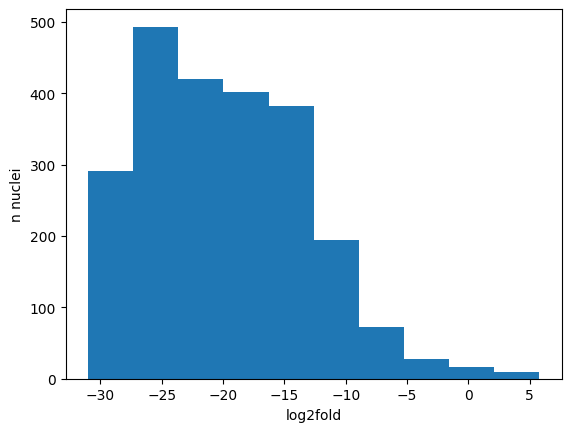

In [ ]:
plt.hist([logfold for idx, iplane, logfold in logfold_diffs])
plt.xlabel('log2fold')
plt.ylabel('n nuclei');

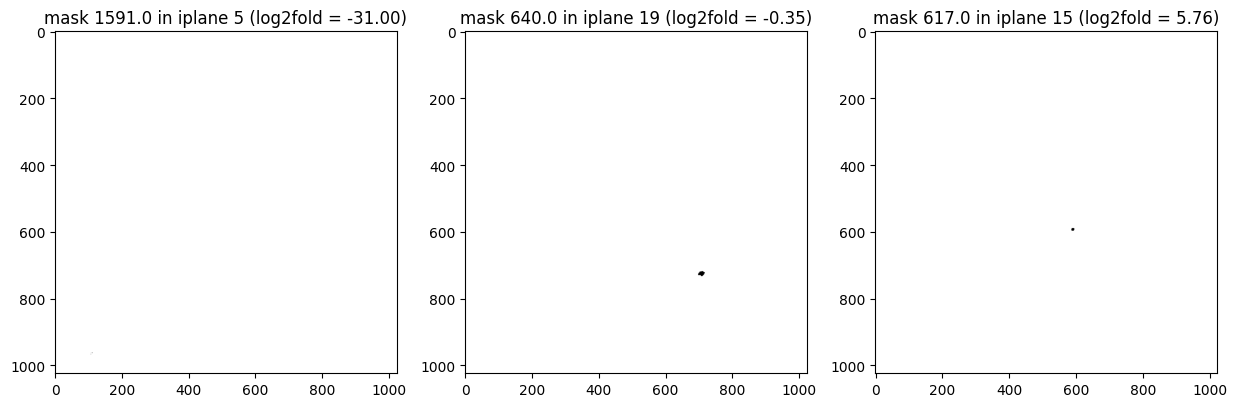

In [ ]:
#@markdown [show max negative, near 0 and max positive log2fold]
plt.figure(figsize=(15,5))

#max negative
mask_id, iplane, logfold = sorted(logfold_diffs, key= lambda x : x[2])[0]

#isolate mask
iplane_matrix = label_matrix[iplane, :, :]
mask = iplane_matrix == mask_id

#show the mask, isolated
plt.subplot(1,3,1)
plt.imshow(mask, cmap='binary')
plt.title(f'mask {mask_id} in iplane {iplane} (log2fold = {logfold:.2f})')

#near 0
mask_id, iplane, logfold = [x for x in logfold_diffs if round(x[2]) == 0][0]


#isolate mask
iplane_matrix = label_matrix[iplane, :, :]
mask = iplane_matrix == mask_id

#show the mask, isolated
plt.subplot(1,3,2)
plt.imshow(mask, cmap='binary')
plt.title(f'mask {mask_id} in iplane {iplane} (log2fold = {logfold:.2f})')

#max positive
mask_id, iplane, logfold = sorted(logfold_diffs, key= lambda x : x[2])[-1]

#isolate mask
iplane_matrix = label_matrix[iplane, :, :]
mask = iplane_matrix == mask_id

#show the mask, isolated
plt.subplot(1,3,3)
plt.imshow(mask, cmap='binary')
plt.title(f'mask {mask_id} in iplane {iplane} (log2fold = {logfold:.2f})')
plt.show();

In [ ]:
display(logfold_diffs_df.sort_values(by='log2fold'))

,label_id,biggest_iplane,Vi_O,Vi_E,Vi_E_norm,log2fold
0,1023.0,93.0,0.4335,41474.532643,1.057601e+06,-21.218260
3,873.0,73.0,10.4329,71926.901324,9.292956e+06,-19.764638
9,570.0,35.0,8.3232,4771.414438,3.487904e+05,-15.354862
11,535.0,30.0,9.5081,4770.562409,3.811679e+05,-15.290910
1,985.0,87.0,13.5541,4101.364401,3.486160e+05,-14.650622
...,...,...,...,...,...,...
48,113.0,35.0,1298.6504,167.928563,2.232589e+02,2.540224
24,229.0,37.0,2555.6848,168.701022,2.901658e+02,3.138761
57,85.0,34.0,1357.4041,79.306807,1.092225e+02,3.635508
30,161.0,28.0,323.8534,12.947254,1.039377e+01,4.961550


In [ ]:
display(logfold_diffs_df[(logfold_diffs_df['log2fold'] > -2) &
                         (logfold_diffs_df['log2fold'] < 2)
                            ].sort_values(by='log2fold'))

,label_id,biggest_iplane,Vi_O,Vi_E,Vi_E_norm,log2fold
31,156.0,17.0,690.5944,1504.056343,2292.389322,-1.730942
52,100.0,44.0,1284.6050,1611.894016,2822.017435,-1.135402
25,223.0,44.0,790.3283,1203.320872,1730.930793,-1.131024
28,210.0,28.0,578.8092,925.554125,1027.982115,-0.828655
41,130.0,36.0,1491.9625,1869.531862,2603.829918,-0.803424
42,127.0,21.0,788.8255,809.154260,1375.562242,-0.802243
53,96.0,77.0,1304.0836,1684.740718,2242.937944,-0.782353
63,71.0,18.0,1099.9051,763.793604,1357.469541,-0.303541
7,579.0,60.0,23.6980,21.718234,29.009356,-0.291753
62,73.0,0.0,1331.8565,798.238783,1302.725694,0.031905


In [ ]:
display(logfold_diffs_df[(logfold_diffs_df['log2fold'] < -2)
                            ].sort_values(by='log2fold').head(5))

,label_id,biggest_iplane,Vi_O,Vi_E,Vi_E_norm,log2fold
0,1023.0,93.0,0.4335,41474.532643,1.057601e+06,-21.218260
3,873.0,73.0,10.4329,71926.901324,9.292956e+06,-19.764638
9,570.0,35.0,8.3232,4771.414438,3.487904e+05,-15.354862
11,535.0,30.0,9.5081,4770.562409,3.811679e+05,-15.290910
1,985.0,87.0,13.5541,4101.364401,3.486160e+05,-14.650622


In [ ]:
display(logfold_diffs_df[(logfold_diffs_df['log2fold'] > 0)
                            ].sort_values(by='log2fold'))

,label_id,biggest_iplane,Vi_O,Vi_E,Vi_E_norm,log2fold
62,73.0,0.0,1331.8565,798.238783,1302.725694,0.031905
8,575.0,55.0,275.5326,41.070740,142.134096,0.954970
48,113.0,35.0,1298.6504,167.928563,223.258872,2.540224
24,229.0,37.0,2555.6848,168.701022,290.165758,3.138761
57,85.0,34.0,1357.4041,79.306807,109.222540,3.635508
30,161.0,28.0,323.8534,12.947254,10.393768,4.961550
70,54.0,52.0,134.3272,3.855068,2.313041,5.859817


# Export

In [ ]:
#outfile_name = ""
#tifffile.imwrite(outfile_name, refined_label_matrix, bigtiff=True)